# Topic Modeling

# Purpose: 
<h4 style="margin-bottom: 1;"> I analyzed Country music lyrics to uncover the genre's core themes through applying topic modeling techniques and diving into the stories that resonate with so many listeners. </h4>

![Alt text](Images/Project_Scope.png)

# Featured Songs
## [Playlist: Click Here to Access via Spotify](https://open.spotify.com/playlist/6wS1RaOrTQiwlNTOuFyJcx?si=686ab2a0fa4444f0)

![Alt text](Images/Playlist_A.png)

![Alt text](Images/Playlist_B.png)

![Alt text](Images/Playlist_C.png)

## Initial Setup

In [1]:
# Import Required Libraries
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx
import pandas as pd
import numpy as np
import warnings
import random
import nltk
import re

#--
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from tabulate import tabulate
from PIL import Image

In [2]:
%%capture

# Download NLTK Files Only If They Haven't Been Downloaded Already
nltk.download('stopwords', quiet=True)

In [3]:
# Ignore All Warnings 
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Load Artist Hometown Data
Artist_Hometowns = pd.read_excel('Data/Artist_Hometowns.xlsx')

# Load Song Lyrics
song_lyrics = pd.read_excel('Data/song_lyrics.xlsx')

# Data Exploration

### Preprocess Song Lyrics

In [5]:
# Define Function to Preprocess Lyrics
def preprocess_lyrics(lyrics):
    stop_words = set(stopwords.words('english'))

    # Process lyrics: clean, tokenize, and remove stopwords
    tokens = [
        word for word in nltk.word_tokenize(re.sub(r'[^a-zA-Z\s]', '', lyrics.lower()))
        if word not in stop_words
    ]
    return tokens

In [6]:
# Apply Pre-Processing to the Lyrics Column
song_lyrics['Processed_Lyrics'] = song_lyrics['Lyrics'].apply(preprocess_lyrics)

# Convert Processed Lyrics Back to String Form for Analysis
song_lyrics['Processed_Text'] = song_lyrics['Processed_Lyrics'].apply(lambda x: ' '.join(x))

# Preview the DataFrame
song_lyrics.head()

,Song_Title,Release_Date,Artists,Lyrics,Processed_Lyrics,Processed_Text
0,Oklahoma Smokeshow,2022-07-15,Zach Bryan,Go on and put on that dress that all the bad b...,"[go, put, dress, bad, boys, like, know, daddy,...",go put dress bad boys like know daddy aint hom...
1,Heading South,2019-09-30,Zach Bryan,"Was a boy who was a dreamer, and he flew so hi...","[boy, dreamer, flew, high, proud, world, full,...",boy dreamer flew high proud world full people ...
2,Revival,2020-05-08,Zach Bryan,"Gather 'round this table, boys\nBring your sha...","[gather, round, table, boys, bring, shame, ill...",gather round table boys bring shame ill lose v...
3,Nine Ball,2023-09-22,Zach Bryan,"I don't wanna bet, but my father wrote a check...","[dont, wan, na, bet, father, wrote, check, bet...",dont wan na bet father wrote check bet ass cou...
4,From Austin,2022-02-25,Zach Bryan,There is concrete below me and a sky above so ...,"[concrete, sky, blue, im, finally, leaving, au...",concrete sky blue im finally leaving austin wi...


### Extract Individual Artists that Worked on a Song

In [7]:
# Define function to extract artists and handle specific names
def extract_artists(artist_string):
    artists = str(artist_string).split(',')
    artists = [artist.strip() for artist in artists if artist.strip()]
    return artists

# Create a column to store the artists in list format
song_lyrics['Artist_List'] = song_lyrics['Artists'].apply(extract_artists)

# Display artist and the number of songs in playlist
all_artists = [artist for artist_list in song_lyrics['Artist_List'] for artist in artist_list]
artist_counts = Counter(all_artists)

# Convert artist counts to a DataFrame
artist_data = pd.DataFrame(artist_counts.items(), columns=['Artist', 'Number of Songs in Playlist'])

# Merge artist_data with hometown information
artist_data = artist_data.merge(Artist_Hometowns[['Artist', 'Hometown']], on='Artist', how='left')

# Reorder Columns and Display the table
artist_data = artist_data[['Artist', 'Hometown', 'Number of Songs in Playlist']].sort_values(by='Number of Songs in Playlist', ascending=False)
print(tabulate(artist_data, headers=['Artist', 'Hometown', 'Number of Songs in Playlist'], showindex=False))

Artist                    Hometown                        Number of Songs in Playlist
------------------------  ----------------------------  -----------------------------
Willie Nelson             Abbott, Texas                                             9
Luke Combs                Huntersville, North Carolina                              8
Post Malone               Syracuse, New York                                        7
Johnny Cash               Kingsland, Arkansas                                       7
Waylon Jennings           Littlefield, Texas                                        7
Tyler Childers            Lawrence County, Kentucky                                 6
Hank Williams Jr.         Shreveport, Louisiana                                     6
Zach Bryan                Oologah, Oklahoma                                         6
Dolly Parton              Sevierville, Tennessee                                    6
Morgan Wallen             Sneedville, Tennessee       

### Number of Songs by Top Featured Artists Visual

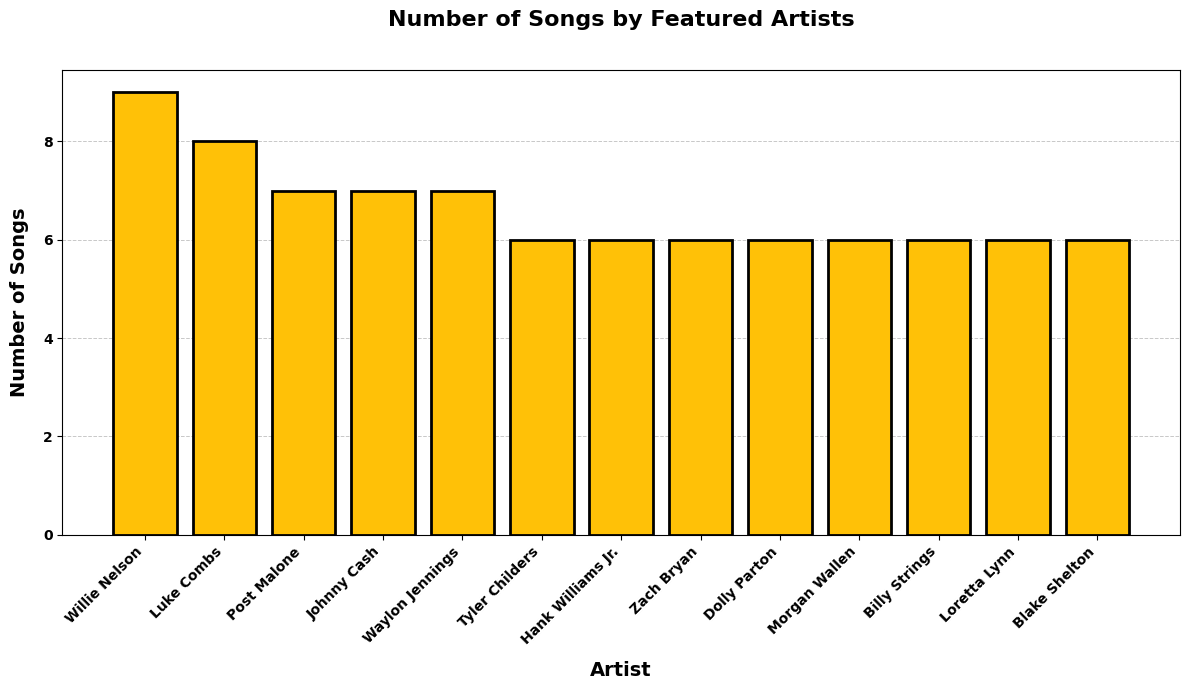

In [8]:
# Sort data to display the top artists
artist_data_sorted = artist_data.sort_values(by='Number of Songs in Playlist', ascending=False).head(13)

# Create the bar plot
plt.figure(figsize=(12, 7))
plt.bar(
    artist_data_sorted['Artist'],
    artist_data_sorted['Number of Songs in Playlist'],
    color='#FFC107',
    edgecolor='black',
    linewidth=2
)

# Add title and labels
plt.title('Number of Songs by Featured Artists\n', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Artist', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('Number of Songs', fontsize=14, labelpad=10, fontweight='bold')

# Customize ticks
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Add gridlines and ensure they are behind bars
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.gca().set_axisbelow(True)

# Optimize layout and display
plt.tight_layout()
plt.show()

### Geocode Artist Hometowns and Visualize Collaborations

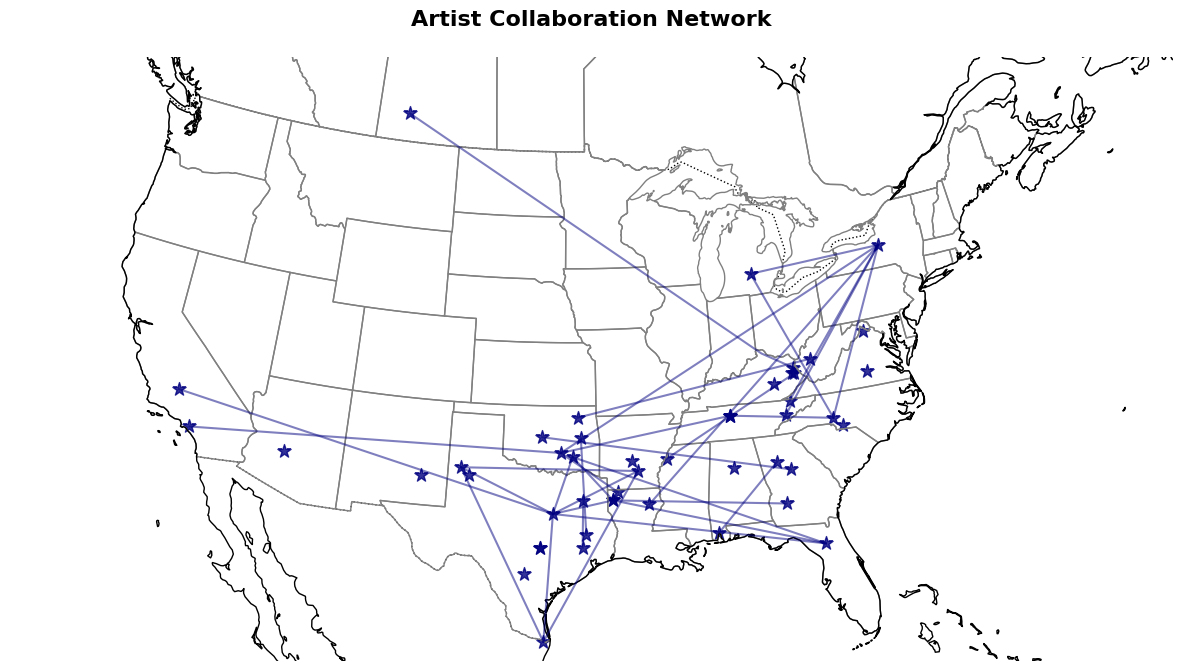

In [9]:
# Geocode Artist Hometown
geolocator = Nominatim(user_agent="artist_map")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
Artist_Hometowns['Location'] = Artist_Hometowns['Hometown'].apply(geocode)
Artist_Hometowns['Latitude'] = Artist_Hometowns['Location'].apply(lambda loc: loc.latitude if loc else None)
Artist_Hometowns['Longitude'] = Artist_Hometowns['Location'].apply(lambda loc: loc.longitude if loc else None)

# Create a graph for artist collaboration
G = nx.Graph()

# Add nodes for each artist with latitude and longitude as attributes
for _, row in Artist_Hometowns.iterrows():
    G.add_node(row['Artist'], pos=(row['Longitude'], row['Latitude']), hometown=row['Hometown'])

# Ensure 'Artist_List' in song_lyrics is formatted as a list of artist names (if not already)
song_lyrics['Artist_List'] = song_lyrics['Artists'].apply(lambda x: [artist.strip() for artist in x.split(',')])

# Add edges for collaborations
for _, row in song_lyrics.iterrows():
    artists = row['Artist_List']
    if len(artists) > 1:
        for i in range(len(artists)):
            for j in range(i + 1, len(artists)):
                if G.has_node(artists[i]) and G.has_node(artists[j]):
                    G.add_edge(artists[i], artists[j])

# Set up Cartopy map with Lambert Conformal projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.LambertConformal()})
ax.set_extent([-125, -65, 25, 50], crs=ccrs.PlateCarree())  # Zoom into central/eastern US

# Add country, state, and coastline boundaries
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="black")
ax.add_feature(cfeature.STATES, edgecolor="gray")  # Add U.S. state boundaries
ax.add_feature(cfeature.COASTLINE)

# Get positions for nodes from the graph
pos = {artist: (data['pos'][0], data['pos'][1]) for artist, data in G.nodes(data=True)}

# Plot nodes as points on the map
for artist, (lon, lat) in pos.items():
    ax.scatter(lon, lat, transform=ccrs.PlateCarree(), color='#000080', marker='*', s=100, alpha=0.8)

# Draw edges (collaborations) as lines on the map
for u, v in G.edges():
    x = [pos[u][0], pos[v][0]]
    y = [pos[u][1], pos[v][1]]
    ax.plot(x, y, transform=ccrs.PlateCarree(), color='#000080', alpha=0.5)

plt.title("Artist Collaboration Network\n", fontsize=16, fontweight="bold")
plt.axis("off")
plt.show()

### Number of Collaborations between Artists

In [10]:
# Extract collaboration data from song_lyrics
collaboration_data = [
    {
        'Song_Title': row['Song_Title'],
        **{f'Artist_{i+1}': f"{artist} \n ({G.nodes[artist].get('hometown', 'Unknown')})"
           for i, artist in enumerate(row['Artist_List']) if len(row['Artist_List']) > 1 and G.has_node(artist)}
    }
    for _, row in song_lyrics.iterrows() if len(row['Artist_List']) > 1
]

# Convert to DataFrame and save as CSV
collaboration_df = pd.DataFrame(collaboration_data)
collaboration_df.to_csv("collaborations.csv", index=False)

# Print the total number of collaborations
print(f"Total number of collaborations: {len(collaboration_df)}")

Total number of collaborations: 26


### Artist Collaborations

![Alt text](Images/Collaborations_A.png)

![Alt text](Images/Collaborations_B.png)

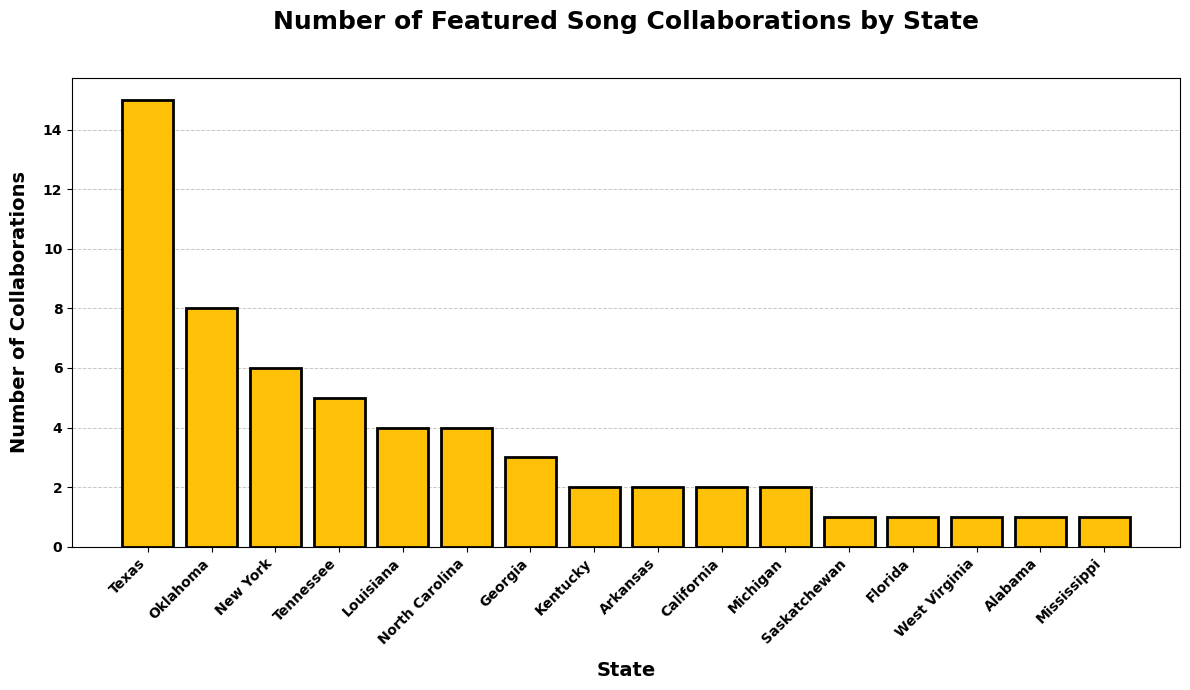

In [11]:
# Extract states and count collaborations
states = collaboration_df.filter(like='Artist').stack().str.extract(r',\s*(.*?)\)')[0]
state_counts = states.value_counts()

# Create bar graph
plt.figure(figsize=(12, 7))
plt.bar(state_counts.index, state_counts.values, color='#FFC107', edgecolor='black', linewidth=2, width=0.8)

# Add title and labels
plt.title('Number of Featured Song Collaborations by State\n', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('State', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('Number of Collaborations', fontsize=14, labelpad=10, fontweight='bold')

# Customize ticks with bold font
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Add gridlines and ensure they're behind bars
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.gca().set_axisbelow(True)

# Optimize layout and display
plt.tight_layout()
plt.show()

### Song Releases Over Time

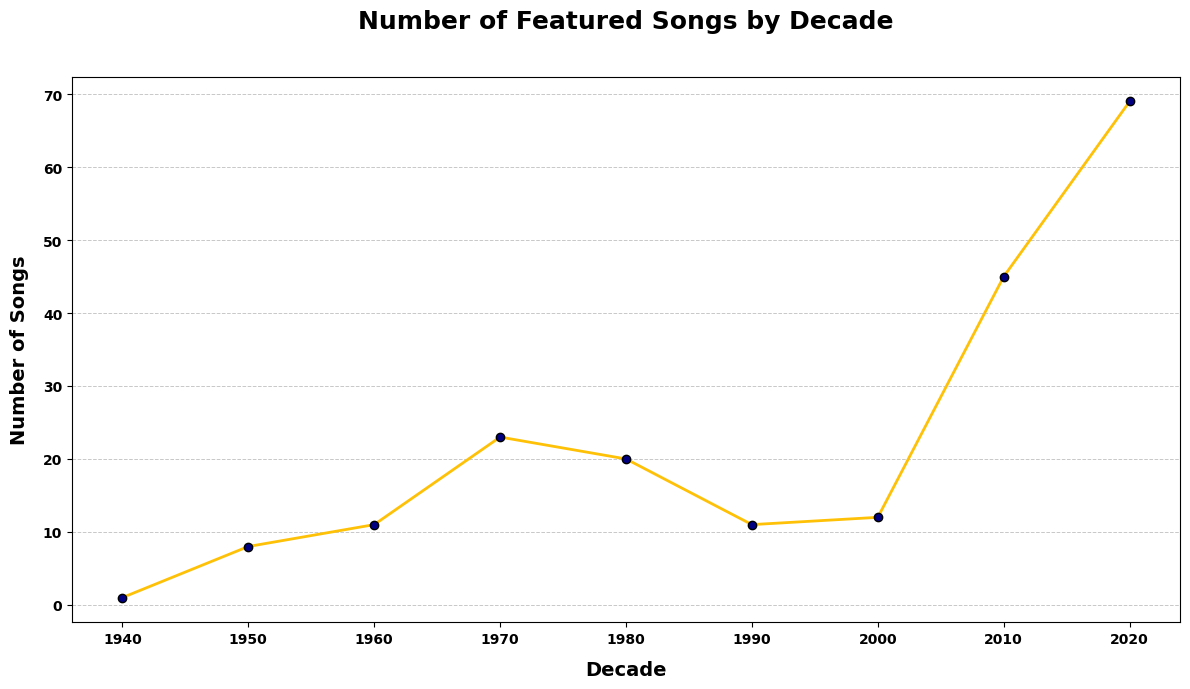

In [12]:
# Convert 'Release_Date' to datetime format
song_lyrics['Release_Date'] = pd.to_datetime(song_lyrics['Release_Date'])

# Group by decade and count the number of songs
song_lyrics['Decade'] = (song_lyrics['Release_Date'].dt.year // 10) * 10
songs_by_decade = song_lyrics['Decade'].value_counts().sort_index()

# Create the line graph
plt.figure(figsize=(12, 7))
plt.plot(songs_by_decade.index, songs_by_decade.values, color='#FFC107', linewidth=2, marker='o', 
         markerfacecolor='#000080', markeredgecolor='black', markersize=6)

# Add title and labels
plt.title('Number of Featured Songs by Decade\n', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Decade', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Songs', fontsize=14, fontweight='bold', labelpad=10)

# Customize x-ticks (decades from 1940's to 2020's)
plt.xticks(range(1940, 2030, 10), fontsize=10, fontweight='bold')

# Customize y-ticks
plt.yticks(fontsize=10, fontweight='bold')

# Add gridlines
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.gca().set_axisbelow(True)

# Display the plot
plt.tight_layout()
plt.show()

### Generate a Wordcloud to Find Frequently Mentioned Words

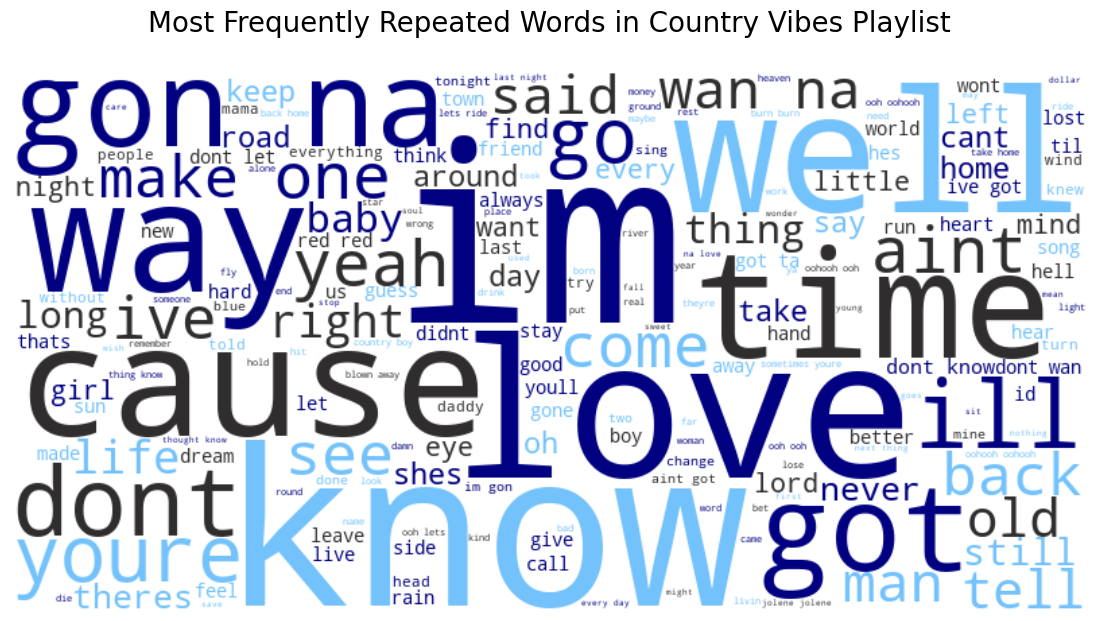

In [13]:
# Combine all processed lyrics into one string for word cloud
all_text = ' '.join([' '.join(words) for words in song_lyrics['Processed_Lyrics']])

# Define the color palette
primary_color = '#000080'
complementary_colors = ['#73C2FB','#2F2D2E']

# Custom color function to use the specified colors
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = [primary_color] + complementary_colors
    return random.choice(colors)

# Generate Word Cloud with custom colors
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=custom_color_func,
    prefer_horizontal=1.0,
    random_state=42
).generate(all_text)

# Display the word cloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequently Repeated Words in Country Vibes Playlist\n", fontsize=20)
plt.show()

<div style="text-align: center; font-size: 20px; font-weight: bold;">
This Visual Offers Limited Insight;
</div>

<div style="text-align: center; font-size: 20px; font-weight: bold;">
However, Topic Modeling Will Add Value Through Introducing a Framework of Country Themes.
</div>

## Topic Modeling

<div style="text-align: center; font-size: 20px; font-weight: bold;">
Framework of Country Themes
</div>

<div style="text-align: center; font-size: 20px; font-weight: bold;">
A Breakdown of Recurring Topics That Group Words With Similar Significance in Country Music Together.
</div>

![Alt text](Images/Topic_Modeling_Themes.png)

## Currently in Progress